# IO.
## Práctica 2, Parte 1 -> Política óptima para circuitos

importaciones

In [9]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Nuestras clases
from racetrack_env import RaceTrackEnv
from mc_agent import MonteCarloAgent

%matplotlib inline

Creamos los mapas con los que haremos las pruebas y creamos los objetos de entorno y agente.

- ENTORNO (racetrack_env.py): Simula la física de un coche con inercia en una cuadrícula discreta. Implementa las reglas establecidas con posición, velocidad, inicio, meta, choques y reinicios entre otras configuraciones.
- AGENTE (mc_agent.py): Implementa un algoritmo de control Monte Carlo. No conoce el mapa, solo aprende a base de prueba y error (episodios completos) actualizando la tabla Q de 5 dimensiones que estima el valor de cada aceleración en cada estado (posición + velocidad).


In [14]:
# Mapa "L-Shape" (Track Left del enunciado)
TRACK_LEFT_STR = [
    "#################",
    "############FFFFF",
    "############FFFFF",
    "############FFFFF",
    "############FFFFF",
    "############FFFFF",
    "############FFFFF",
    "######......FFFFF",
    "######......FFFFF",
    "#####.......#####",
    "####........#####",
    "####........#####",
    "###.........#####",
    "###.........#####",
    "###.........#####",
    "###.........#####",
    "###.........#####",
    "###.........#####",
    "###.........#####",
    "###.........#####",
    "###.........#####",
    "###.........#####",
    "###.........#####",
    "###.........#####",
    "####........#####",
    "####........#####",
    "####........#####",
    "####........#####",
    "#####.......#####",
    "#####.......#####",
    "#####.......#####",
    "#####SSSSSSS#####",
    "#################"
]

# Inicializamos
env = RaceTrackEnv(TRACK_LEFT_STR)
agent = MonteCarloAgent(env)

print(f"Entorno cargado: {env.width}x{env.height}")
print(f"Agente inicializado con Q-Table de tamaño {agent.q_table.size} elementos.")

Entorno cargado: 17x33
Agente inicializado con Q-Table de tamaño 126225 elementos.


Visualizamos el mapa parseado

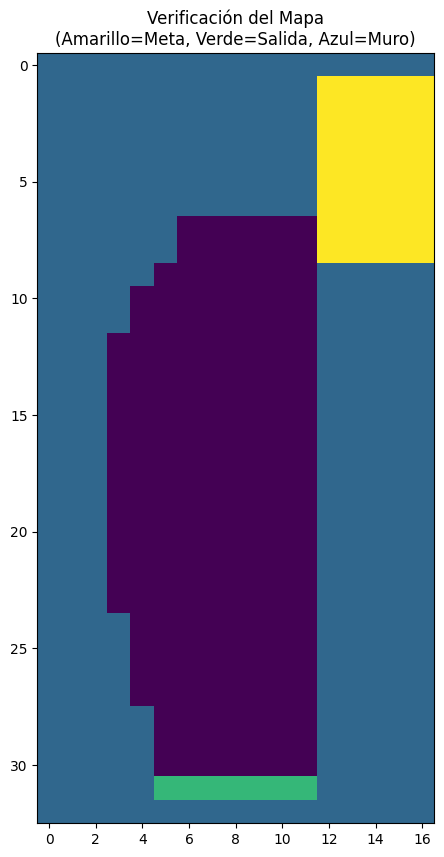

In [11]:
plt.figure(figsize=(6, 10))

# 0(Pista)=Morado, 1(Muro)=Azul, 2(Salida)=Verde, 3(Meta)=Amarillo
plt.imshow(env.track) 
plt.title("Verificación del Mapa\n(Amarillo=Meta, Verde=Salida, Azul=Muro)")
plt.show()

Entrenamiento:

Se ejecutarán 10.000 episodios donde el agente interactúa con el entorno. Se utiliza una política e-greedy con decaimiento (explora mucho  al principio, poco al final) para garantizar la cvonvergencia a una ruta óptima.

In [12]:
# --- CONFIGURACIÓN ---
NUM_EPISODES = 10000    
MAX_STEPS = 2000          # Damos margen al ep 1 para que falle mucho
SNAPSHOT_INTERVAL = 500   # Guardamos cada 500 para el vídeo de evolución
epsilon = 0.1

# Estructura de datos más compleja: Lista de Segmentos
# Un episodio tendrá varios "intentos" (segmentos) si se choca y resetea.
# evolution_history = [ {'episode': 1, 'segments': [[(x,y)...], [(x,y)...]]}, ... ]
evolution_history = [] 

print(f"Iniciando entrenamiento de {NUM_EPISODES} episodios...")
start_time = time.time()


# --- BUCLE DE ENTRENAMIENTO OPTIMIZADO ---
for i in range(NUM_EPISODES):
    state = env.reset()
    done = False
    steps = 0
    
    # ¿Toca grabar este episodio para el vídeo?
    # Solo grabamos el primero (0) y los múltiplos del intervalo
    record_video = (i == 0 or (i + 1) % SNAPSHOT_INTERVAL == 0)

    # Variables solo para grabación
    current_segments = []       
    current_segment_path = []   
    if record_video:
        current_segment_path.append((state[0], state[1]))
    
    current_epsilon = max(0.01, epsilon * (1 - i/NUM_EPISODES)) 
    episode = [] # Para el aprendizaje (siempre necesario)

    while not done and steps < MAX_STEPS:
        # --- 1. LÓGICA DE GRABACIÓN (Solo si toca vídeo) ---
        if record_video:
            # Predecir física para detectar reset
            x, y, vx, vy = state
            action_idx = agent.get_action(state, current_epsilon)
            
            # Calculamos predicción teórica
            ax_val, ay_val = env.actions[action_idx]
            pred_vx = int(np.clip(vx + ax_val, 0, 4))
            pred_vy = int(np.clip(vy + ay_val, 0, 4))
            pred_x = x + pred_vx
            pred_y = y - pred_vy
            
            # Paso real
            next_state, reward, done = env.step(action_idx)
            
            # Detectar reset comparando realidad vs predicción
            has_reset = (next_state[0] != pred_x) or (next_state[1] != pred_y)
            
            if has_reset:
                current_segment_path.append((pred_x, pred_y)) # Punto del choque
                current_segments.append(current_segment_path)
                current_segment_path = [(next_state[0], next_state[1])] # Nueva salida
            else:
                current_segment_path.append((next_state[0], next_state[1]))

        # --- 2. LÓGICA RÁPIDA (Para el 99% de los episodios) ---
        else:
            action_idx = agent.get_action(state, current_epsilon)
            next_state, reward, done = env.step(action_idx)

        # Común para ambos casos: Guardar experiencia para aprender
        episode.append((state, action_idx, reward))
        state = next_state
        steps += 1

    # Al terminar, si estábamos grabando, cerramos el segmento
    if record_video:
        current_segments.append(current_segment_path)
        
        # Guardamos en el historial global
        evolution_history.append({
            'episode': i + 1,
            'segments': current_segments,
            'result': 'Meta' if done else 'Tiempo'
        })

    # Aprendizaje (Siempre)
    if done:
        agent.update(episode)
    
    if (i + 1) % 1000 == 0:
        elapsed = time.time() - start_time
        print(f"Episodio {i+1} completado. Tiempo: {elapsed:.0f}s")

Iniciando entrenamiento de 10000 episodios...
Episodio 1000 completado. Tiempo: 1s
Episodio 2000 completado. Tiempo: 2s
Episodio 3000 completado. Tiempo: 2s
Episodio 4000 completado. Tiempo: 3s
Episodio 5000 completado. Tiempo: 3s
Episodio 6000 completado. Tiempo: 3s
Episodio 7000 completado. Tiempo: 4s
Episodio 8000 completado. Tiempo: 4s
Episodio 9000 completado. Tiempo: 5s
Episodio 10000 completado. Tiempo: 5s


Vamos a generar dos gifs para ver la evolución de cómo aprende hasta completar el primer episodio, y luego otrro gif qwue resume los siguientes episodios de 500 en 500, así viendo una evolución global del entrenamiento.

In [13]:
# --- FUNCIÓN MAESTRA DE ANIMACIÓN (GRISES PERSISTENTES) ---
def create_smart_animation(data_subset, filename, target_duration_sec=10, title_prefix=""):
    
    # 1. CÁLCULO PREVIO DE FRAMES (Igual que antes)
    total_raw_steps = 0
    for ep_data in data_subset:
        for segment in ep_data['segments']:
            total_raw_steps += len(segment)
            
    target_fps = 50
    target_total_frames = target_duration_sec * target_fps
    step_skip = max(1, total_raw_steps // target_total_frames)
    
    print(f"\nGenerando {filename} (Modo Persistente)...")
    print(f"   Datos totales: {total_raw_steps} pasos. Skip: {step_skip}.")
    
    # --- CONFIGURACIÓN GRÁFICA ---
    fig, ax = plt.subplots(figsize=(6, 10))
    ax.imshow(env.track, cmap='gray_r')
    ax.axis('off')

    line_red, = ax.plot([], [], 'r-', linewidth=2, label='Intento Actual', zorder=10)
    point, = ax.plot([], [], 'ro', markersize=6, markeredgecolor='black', zorder=11)
    gray_lines_artists = [] # Lista que acumulará TODAS las líneas grises
    title_text = ax.text(0.5, 1.02, "", transform=ax.transAxes, ha="center", fontsize=10, weight='bold')

    def init():
        line_red.set_data([], [])
        point.set_data([], [])
        # Aseguramos que la lista de grises empieza limpia
        for art in gray_lines_artists: art.remove()
        gray_lines_artists.clear()
        return line_red, point, title_text

    # Generador de datos
    def data_gen():
        # Yield inicial para limpiar el lienzo al empezar el vídeo
        if data_subset:
             yield 'CLEAR_CANVAS', None, None, data_subset[0]['episode']

        for ep_data in data_subset:
            ep_num = ep_data['episode']
            segments = ep_data['segments']
            
            # CAMBIO AQUÍ: Ya no limpiamos grises. Solo avisamos de nuevo episodio.
            yield 'NEW_EPISODE_START', None, None, ep_num
            
            for seg_idx, segment in enumerate(segments):
                xs = [p[0] for p in segment]
                ys = [p[1] for p in segment]
                is_last_segment = (seg_idx == len(segments) - 1)
                
                # Bucle de dibujo (con salto de frames)
                for k in range(0, len(xs), step_skip):
                    idx = k
                    if idx + step_skip >= len(xs): idx = len(xs) - 1
                    
                    current_xs = xs[:idx+1]
                    current_ys = ys[:idx+1]
                    
                    yield 'DRAW', current_xs, current_ys, (ep_num, seg_idx + 1)
                
                # Convertir a gris si chocó (y se quedará ahí para siempre)
                if not is_last_segment:
                    yield 'FREEZE_GRAY', xs, ys, ep_num

    def run(data):
        action, xs, ys, info = data
        
        if action == 'CLEAR_CANVAS':
            # Solo se llama una vez al principio del todo
            for art in gray_lines_artists:
                art.remove()
            gray_lines_artists.clear()
            title_text.set_text(f"{title_prefix} Iniciando...")

        elif action == 'NEW_EPISODE_START':
            # Solo actualiza el título, NO borra las líneas grises
            title_text.set_text(f"{title_prefix} Episodio: {info}")
            # Limpiamos la línea roja para empezar el nuevo episodio limpio
            line_red.set_data([], [])

        elif action == 'FREEZE_GRAY':
            # Pinta el segmento fallido en gris y lo añade a la lista persistente
            l, = ax.plot(xs, ys, color='gray', linewidth=1, alpha=0.3, zorder=1)
            gray_lines_artists.append(l)
            line_red.set_data([], [])
            
        elif action == 'DRAW':
            ep_num, try_num = info
            title_text.set_text(f"{title_prefix} Ep: {ep_num} | Intento: {try_num}")
            line_red.set_data(xs, ys)
            point.set_data([xs[-1]], [ys[-1]])
            
        return line_red, point, title_text

    # Guardar
    frames_est = (total_raw_steps // step_skip) + (len(data_subset) * 10)
    
    anim = animation.FuncAnimation(fig, run, data_gen, init_func=init,
                                   save_count=frames_est, interval=1000//target_fps, 
                                   blit=False, repeat=False)
    
    try:
        anim.save(filename, writer='pillow', fps=target_fps)
        print(f"✅ ¡Guardado {filename}!")
    except Exception as e:
        print(f"❌ Error: {e}")
        
    plt.close(fig)

# --- LLAMADAS PARA GENERAR LOS VÍDEOS (10 SEGUNDOS CADA UNO) ---

# 1. Vídeo del Episodio 1 (Novato)
data_ep1 = [d for d in evolution_history if d['episode'] == 1]
if data_ep1:
    # En el ep 1 da igual que sea persistente porque solo hay un episodio,
    # pero usaremos la misma función.
    create_smart_animation(data_ep1, 'episodio_1_rapido.gif', target_duration_sec=10, title_prefix="NOVATO -")

# 2. Vídeo de Evolución (Progreso acumulado)
data_evo = [d for d in evolution_history if d['episode'] > 1]
if data_evo:
    # AQUÍ es donde se notará el efecto: los grises del ep 500 seguirán ahí en el ep 1000.
    create_smart_animation(data_evo, 'evolucion_aprendizaje.gif', target_duration_sec=10, title_prefix="PROGRESO -")


Generando episodio_1_rapido.gif (Modo Persistente)...
   Datos totales: 683 pasos. Skip: 1.
✅ ¡Guardado episodio_1_rapido.gif!

Generando evolucion_aprendizaje.gif (Modo Persistente)...
   Datos totales: 226 pasos. Skip: 1.
✅ ¡Guardado evolucion_aprendizaje.gif!
